# Setup

In [3]:
import os
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path
import IPython.display as ipd
import sklearn as skl
import pandas as pd

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim 

In [4]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

cuda


In [5]:
gtzan_dir = Path(str(os.environ.get('GTZAN_DIR')))   #C:/VisualStudioRepositories/MUSIC_DATA/gt/Data
fma_dir = Path(str(os.environ.get('FMA_DIR')))       #C:/VisualStudioRepositories/MUSIC_DATA/fma

gtzan_image_dir = gtzan_dir / 'spectrograms'
gtzan_df_path = gtzan_dir / 'gtzan_df.csv'

fma_small_image_dir = fma_dir / 'spectrograms/fma_small'
fma_medium_image_dir = fma_dir / 'spectrograms/fma_medium'
fma_df_path = fma_dir / 'fma_df.csv'

In [6]:
gtzan_classes = ['Blues', 'Classical', 'Country', 'Disco', 'Hip-Hop', 'Jazz', 'Metal', 'Pop', 'Reggae', 'Rock'] #10
fma_top_classes = ['Electronic', 'Experimental', 'Folk', 'Hip-Hop', 'Instrumental', 'International', 'Pop', 'Rock'] #8

In [7]:
IMAGE_SIZE = 128    #128x128 px images for the CNN (with 3 channels)

# Define function loading GTZAN df from file

In [35]:
def get_gtzan_dataframe(with_val):
    gtzan_df = pd.read_csv(gtzan_df_path)
    
    # turn relative paths into absolute paths
    gtzan_df['path'] = gtzan_df['path'].apply(lambda x: gtzan_image_dir / x)
    
    # SAMPLES: 800/90/108
    if (with_val):
        gtzan_train_df = gtzan_df[gtzan_df['set'] == 'train']
        gtzan_val_df = gtzan_df[gtzan_df['set'] == 'validation']
        gtzan_test_df = gtzan_df[gtzan_df['set'] == 'test']
        return gtzan_train_df, gtzan_val_df, gtzan_test_df
    else: # SAMPLES: 800/198
        gtzan_train_df = gtzan_df[gtzan_df['set'] == 'train']
        gtzan_test_df = gtzan_df[(gtzan_df['set'] == 'test') | (gtzan_df['set'] == 'validation')]
        return gtzan_train_df, gtzan_test_df

# Load GTZAN df (with/without separate val set)

In [36]:
# with separate val
gtzan_train_df, gtzan_val_df, gtzan_test_df = get_gtzan_dataframe(with_val=True)

In [ ]:
# without separate val
gtzan_train_df, gtzan_test_df = get_gtzan_dataframe(with_val=False)

# Define function loading FMA df from file

In [1]:
def get_fma_dataframe(get_fma_small, with_val):
    fma_df = pd.read_csv(fma_df_path)
    
    # turn relative paths into absolute paths
    fma_df['path'] = fma_df['path'].apply(lambda x: fma_medium_image_dir / x)
    
    # otherwise the dataset is FMA-medium
    if (get_fma_small):
        fma_df = fma_df[fma_df['size'] == 'small']
    
    # PERCENTAGES: 80/10/10
    if (with_val):
        fma_train_df = fma_df[fma_df['set'] == 'training']
        fma_val_df = fma_df[fma_df['set'] == 'validation']
        fma_test_df = fma_df[fma_df['set'] == 'test']
        return fma_train_df, fma_val_df, fma_test_df
    else: # PERCENTAGES: 80/20
        fma_train_df = fma_df[fma_df['set'] == 'training']
        fma_test_df = fma_df[(fma_df['set'] == 'test') | (fma_df['set'] == 'validation')]
        return fma_train_df, fma_test_df

# Load FMA df (with/without separate val set) (small/medium)

In [8]:
# fma-small with separate val
fma_small_train_df, fma_small_val_df, fma_small_test_df = get_fma_dataframe(get_fma_small=True, with_val=True)

In [ ]:
# fma-small without separate val
fma_small_train_df, fma_small_test_df = get_fma_dataframe(get_fma_small=True, with_val=False)

In [ ]:
# fma-medium with separate val
fma_medium_train_df, fma_medium_val_df, fma_medium_test_df = get_fma_dataframe(get_fma_small=False, with_val=True)

In [ ]:
# fma-medium without separate val
fma_medium_train_df, fma_medium_test_df = get_fma_dataframe(get_fma_small=False, with_val=False)

# Define input data loading functions - PyTorch

In [9]:
from PIL import Image

def one_hot_encode_class_label(class_name, available_classes):
  label = available_classes.index(class_name)
  one_hot = np.zeros(len(available_classes))
  one_hot[label] = 1
  return one_hot

# decode png
def decode_img_data(img_path, channels=3):
  img = Image.open(img_path).convert('RGB' if channels == 3 else 'L') # convert to RGB if 3 channels, otherwise grayscale
  img = img.resize((IMAGE_SIZE, IMAGE_SIZE))
  img = np.array(img)
  img = torch.tensor(img).permute(2, 0, 1) if channels == 3 else torch.tensor(img).unsqueeze(0) # channels first
  return img.float() / 255.0 # normalize to [0, 1]

# return pair: decoded png and class name turned into one-hot-encoded label
def process_sample(sample, available_classes, channels=3):
  img_path = sample[0]
  class_label = sample[1]
  
  img_data = decode_img_data(img_path, channels)
  numerical_label = one_hot_encode_class_label(class_label, available_classes)
  return img_data, numerical_label

In [10]:
from torch.utils.data import Dataset, DataLoader

class CustomDataset(Dataset):
    def __init__(self, df, available_classes, channels=3):
        self.df = df
        self.available_classes = available_classes
        self.channels = channels

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        img_path = self.df.iloc[idx]['path']
        class_label = self.df.iloc[idx]['genre']
        img_data, one_hot_label = process_sample((img_path, class_label), self.available_classes, self.channels)
        return img_data.to(device), torch.tensor(one_hot_label, device=device)

def prepare_dataloader_based_on_df(df, available_classes, batch_size=8, channels=3):
    dataset = CustomDataset(df, available_classes, channels)
    dataloader = DataLoader(dataset, batch_size=batch_size, num_workers=0, shuffle=True)
    return dataloader


In [11]:
# on Windows has to be called with num_workers=0 on DataLoader due to multiprocessing issues
def visualize_samples_from_dataloader_batch(dl, available_classes, samples=6):
    image_batch, label_batch = next(iter(dl))
    samples = samples if samples <= len(label_batch) else len(label_batch)
    
    fig, axes = plt.subplots(ncols=3, nrows=(samples + 2) // 3)
    [axis.set_axis_off() for axis in axes.ravel()]
    
    for i in range(samples):
        ax = axes.flat[i]
        img = image_batch[i].permute(1, 2, 0).numpy()  # Convert from (C, H, W) to (H, W, C)
        ax.imshow(img)
        ax.set_title(available_classes[torch.argmax(label_batch[i]).item()])

# Create GTZAN DataLoaders

With val

In [38]:
BATCH_SIZE = 8
CHANNELS = 3

In [39]:
gtzan_train_dl = prepare_dataloader_based_on_df(gtzan_train_df, gtzan_classes, BATCH_SIZE, CHANNELS)

In [40]:
gtzan_val_dl = prepare_dataloader_based_on_df(gtzan_val_df, gtzan_classes, BATCH_SIZE, CHANNELS)

In [41]:
gtzan_test_dl = prepare_dataloader_based_on_df(gtzan_test_df, gtzan_classes, BATCH_SIZE, CHANNELS)

# Visualize GTZAN inputs

Done with num_workers = 0 on DataLoader and with cpu

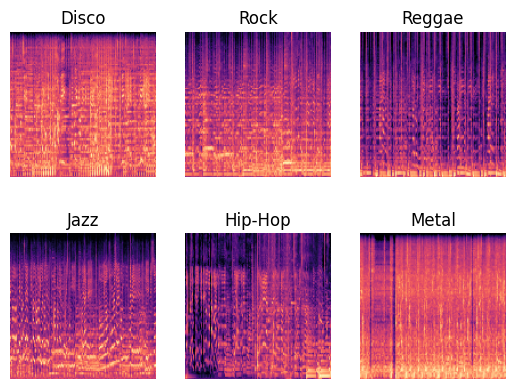

In [39]:
visualize_samples_from_dataloader_batch(gtzan_train_dl, gtzan_classes, samples=6)

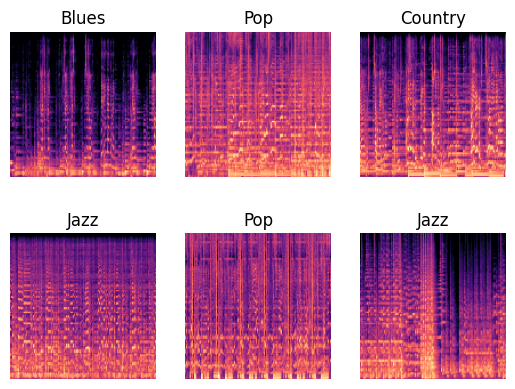

In [43]:
visualize_samples_from_dataloader_batch(gtzan_test_dl, gtzan_classes, samples=6)

# CNN model and loops - PyTorch

In [12]:
# 4 convolutional layers
# layer 1 and 2:
#   64 kernels 5x5 each,
#   RELU,
#   batch normalization,
#   2d max pooling kernel size 2 stride 2
#   
# layer 3 and 4:
#   128 kernels 5x5 each,
#   RELU,
#   batch normalization,
#   2d max pooling - kernel size 2 stride 2
#
# dropout 0.2
#
# output:
#   fully connected linear layer

class CNN(nn.Module):
    def __init__(self, img_size, channels, num_classes):
        super(CNN, self).__init__()
        self.conv1 = nn.Conv2d(channels, 64, kernel_size=5, stride=1, padding=2)
        self.bn1 = nn.BatchNorm2d(64)
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2, padding=0)
        self.dropout = nn.Dropout(0.2)
        
        self.conv2 = nn.Conv2d(64, 64, kernel_size=5, stride=1, padding=2)
        self.bn2 = nn.BatchNorm2d(64)
        
        self.conv3 = nn.Conv2d(64, 128, kernel_size=5, stride=1, padding=2)
        self.bn3 = nn.BatchNorm2d(128)
        
        self.conv4 = nn.Conv2d(128, 128, kernel_size=5, stride=1, padding=2)
        self.bn4 = nn.BatchNorm2d(128)
        
        self.fc = nn.Linear(128 * (img_size // 16) * (img_size // 16), num_classes)
        
    def forward(self, x):
        x = x.to(device)
        x = self.pool(F.relu(self.bn1(self.conv1(x))))
        x = self.dropout(x)
        x = self.pool(F.relu(self.bn2(self.conv2(x))))
        x = self.dropout(x)
        x = self.pool(F.relu(self.bn3(self.conv3(x))))
        x = self.dropout(x)
        x = self.pool(F.relu(self.bn4(self.conv4(x))))
        x = self.dropout(x)
        x = x.view(-1, 128 * (IMAGE_SIZE // 16) * (IMAGE_SIZE // 16))
        x = self.fc(x)
        return x

In [13]:
# multiclass_metrics=[tf.keras.metrics.SparseCategoricalAccuracy(),
#                     #tf.keras.metrics.AUC(curve='ROC'),
#                 ]

In [23]:
def training_loop(model, epochs, train_dl, val_dl = None):
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=0.001)
    
    # Training loop
    for epoch in range(epochs):
        model.train()
        running_loss = 0.0
        for inputs, labels in train_dl:
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, torch.argmax(labels, dim=1))
            loss.backward()
            optimizer.step()
            running_loss += loss.item()
        print(f"Epoch {epoch+1}, Loss: {running_loss/len(train_dl)}")
        
        if val_dl is not None:
            # Validation at end of epoch
            model.eval()
            correct = 0
            total = 0
            with torch.no_grad():
                for inputs, labels in val_dl:
                    outputs = model(inputs)
                    _, predicted = torch.max(outputs, 1)
                    total += labels.size(0)
                    correct += (predicted == torch.argmax(labels, dim=1)).sum().item()
            print(f"Validation Accuracy: {100 * correct / total}%")

In [24]:
# Evaluation loop
def test_loop(model, test_dl):
    model.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for inputs, labels in test_dl:
            outputs = model(inputs)
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == torch.argmax(labels, dim=1)).sum().item()
    print(f"Test Accuracy: {100 * correct / total}%")

# Create and train GTZAN model

In [42]:
model_gtzan = CNN(img_size=IMAGE_SIZE, channels=CHANNELS, num_classes=len(gtzan_classes)).to(device)

In [43]:
training_loop(model_gtzan, 8, gtzan_train_dl, gtzan_val_dl)

Epoch 1, Loss: 2.929658129811287
Validation Accuracy: 32.22222222222222%
Epoch 2, Loss: 2.1297925341129305
Validation Accuracy: 34.44444444444444%
Epoch 3, Loss: 1.6900297820568084
Validation Accuracy: 44.44444444444444%
Epoch 4, Loss: 1.659255606532097
Validation Accuracy: 44.44444444444444%
Epoch 5, Loss: 1.2831114256381988
Validation Accuracy: 40.0%
Epoch 6, Loss: 1.37077831864357
Validation Accuracy: 43.333333333333336%
Epoch 7, Loss: 1.1298013472557067
Validation Accuracy: 61.111111111111114%
Epoch 8, Loss: 1.0097890819609165
Validation Accuracy: 58.888888888888886%


In [44]:
test_loop(model_gtzan, gtzan_test_dl)

Test Accuracy: 62.96296296296296%


# Load FMA-small inputs

With val

In [14]:
BATCH_SIZE = 8
CHANNELS = 3

In [19]:
fma_small_train_dl = prepare_dataloader_based_on_df(fma_small_train_df, fma_top_classes, BATCH_SIZE, CHANNELS)
fma_small_val_dl = prepare_dataloader_based_on_df(fma_small_val_df, fma_top_classes, BATCH_SIZE, CHANNELS)
fma_small_test_dl = prepare_dataloader_based_on_df(fma_small_test_df, fma_top_classes, BATCH_SIZE, CHANNELS)

# Create and train FMA-small model

In [20]:
model_fma_small = CNN(img_size=IMAGE_SIZE, channels=CHANNELS, num_classes=len(fma_top_classes)).to(device)

In [22]:
training_loop(model_fma_small, 8, fma_small_train_dl, fma_small_val_dl)

Epoch 1, Loss: 2.083809417039156
Validation Accuracy: 31.5%
Epoch 2, Loss: 1.6647054379433393
Validation Accuracy: 38.125%
Epoch 3, Loss: 1.5345848057791591
Validation Accuracy: 40.875%
Epoch 4, Loss: 1.4832319397851825
Validation Accuracy: 46.375%
Epoch 5, Loss: 1.4342508152127267
Validation Accuracy: 31.5%
Epoch 6, Loss: 1.400188159532845
Validation Accuracy: 46.875%
Epoch 7, Loss: 1.359112393297255
Validation Accuracy: 48.5%
Epoch 8, Loss: 1.3095306254550814
Validation Accuracy: 41.75%


In [28]:
test_loop(model_fma_small, fma_small_test_dl)

Test Accuracy: 37.875%


# Function definition for binary classification

In [28]:
def trim_dataframe_to_binary_classification(df, class1, class2):
    return df[(df['genre'] == class1) | (df['genre'] == class2)]

# Define binary metrics

In [35]:
binary_metrics=[tf.keras.metrics.BinaryAccuracy(),
                    #tf.keras.metrics.AUC(curve='ROC'),
                ]

# GTZAN binary classification

In [ ]:
#todo - actually find the 2 best classes

In [31]:
BATCH_SIZE = 8
CHANNELS = 3

In [26]:
GTZAN_CLASS_1 = 'Classical'
GTZAN_CLASS_2 = 'Metal'
gtzan_binary_classes = [GTZAN_CLASS_1, GTZAN_CLASS_2]

In [29]:
gtzan_train_df_2 = trim_dataframe_to_binary_classification(gtzan_train_df, *gtzan_binary_classes)
gtzan_val_df_2 = trim_dataframe_to_binary_classification(gtzan_val_df,  *gtzan_binary_classes)
gtzan_test_df_2 = trim_dataframe_to_binary_classification(gtzan_test_df,  *gtzan_binary_classes)

In [ ]:
gtzan_train_ds_2 = prepare_dataloader_based_on_df(gtzan_train_df_2, gtzan_binary_classes, BATCH_SIZE, CHANNELS)
gtzan_val_ds_2 = prepare_dataloader_based_on_df(gtzan_val_df_2, gtzan_binary_classes, BATCH_SIZE, CHANNELS)
gtzan_test_ds_2 = prepare_dataloader_based_on_df(gtzan_test_df_2, gtzan_binary_classes, BATCH_SIZE, CHANNELS)

Example data:
b'C:\\VisualStudioRepositories\\MUSIC_DATA\\gt\\Data\\spectrograms\\Classical\\classical.00000.png' b'Classical'
b'C:\\VisualStudioRepositories\\MUSIC_DATA\\gt\\Data\\spectrograms\\Classical\\classical.00001.png' b'Classical'
b'C:\\VisualStudioRepositories\\MUSIC_DATA\\gt\\Data\\spectrograms\\Classical\\classical.00002.png' b'Classical'
Data set size: 160
Example data:
b'C:\\VisualStudioRepositories\\MUSIC_DATA\\gt\\Data\\spectrograms\\Classical\\classical.00011.png' b'Classical'
b'C:\\VisualStudioRepositories\\MUSIC_DATA\\gt\\Data\\spectrograms\\Classical\\classical.00022.png' b'Classical'
b'C:\\VisualStudioRepositories\\MUSIC_DATA\\gt\\Data\\spectrograms\\Classical\\classical.00027.png' b'Classical'
Data set size: 18
Example data:
b'C:\\VisualStudioRepositories\\MUSIC_DATA\\gt\\Data\\spectrograms\\Classical\\classical.00004.png' b'Classical'
b'C:\\VisualStudioRepositories\\MUSIC_DATA\\gt\\Data\\spectrograms\\Classical\\classical.00006.png' b'Classical'
b'C:\\VisualStudi

In [33]:
model_gtzan_2 = create_CNN(img_size=IMAGE_SIZE, channels=CHANNELS, num_classes=2)

In [36]:
model_gtzan_2.compile(optimizer='adam',
                    loss='binary_crossentropy',
                    metrics=binary_metrics)

In [38]:
model_gtzan_2.fit(
  gtzan_train_ds_2,
  validation_data=gtzan_val_ds_2,
  epochs=2
)

Epoch 1/2


ValueError: Arguments `target` and `output` must have the same rank (ndim). Received: target.shape=(None,), output.shape=(None, 2)

In [ ]:
model_gtzan_2.evaluate(
  gtzan_test_ds_2
)